In [2]:
!pip install arxiv
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 5.8 MB/s 
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=ccb7510263e006b094b953ce0c84b7b43966e0609c9b336dbb74ee4897a1f73d
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36cebfdddfe059f50e019aa
Successfully built sgmllib3k
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=3fd0ba668637a5d03cb8a0b1269ecb02af9b18b19e7ccd0f2029796e763270e8
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import arxiv
import matplotlib.pyplot as plt
from random import randint


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from node2vec import Node2Vec as n2v

generate Facebook network

43.69101262688784
Graph with 4039 nodes and 88234 edges


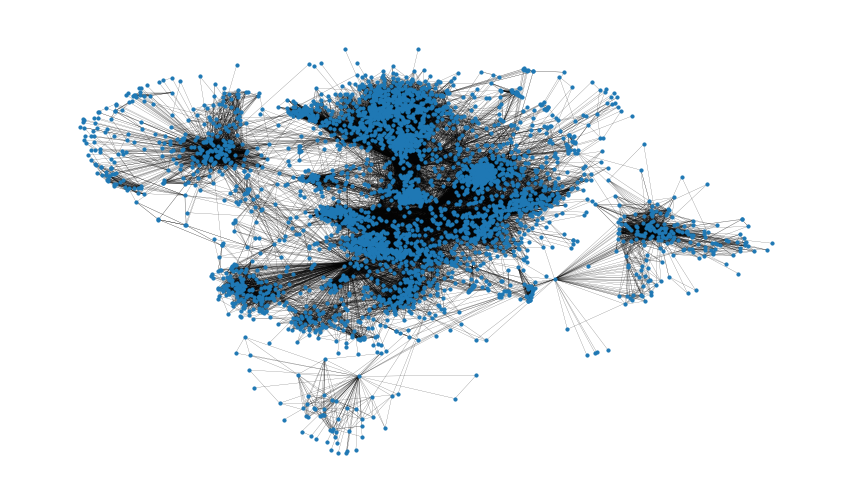

In [4]:
def generate_network(df, node_col = 'person_id', edge_col = 'main_topic'):
    '''
    This function will generate a article to article network given an input DataFrame.
    It will do so by creating an edge_dictionary where each key is going to be a node
    referenced by unique values in node_col and the values will be a list of other nodes
    connected to the key through the edge_col.
    
    params:
        df (DataFrame) : The dataset which holds the node and edge columns
        node_col (String) : The column name associated to the nodes of the network
        edge_col (String) : The column name associated to the edges of the network
        
    returns:
        A networkx graph corresponding to the input dataset
        
    example:
        generate_network(
            research_df,
            node_col = 'person_id',
            edge_col = 'main_topic'
        )
    '''
    edge_dct = {}
    for i,g in df.groupby(node_col):
        topics = g[edge_col].unique()
        edge_df = df[(df[node_col] != i) & (df[edge_col].isin(topics))]
        edges = list(edge_df[node_col].unique())
        edge_dct[i] = edges
    
    # create nx network
    g = nx.Graph(edge_dct, create_using = nx.MultiGraph)
    return g

# research_df = pd.read_csv('./arxiv_data.csv')

# all_tp = research_df.explode('all_topics').copy()

# tp_nx = generate_network(
#     all_tp, 
#     node_col = 'person_id', 
#     edge_col = 'all_topics'
# )

# print(nx.info(tp_nx))

facebook = pd.read_csv(
    "./facebook_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
# print(facebook.head)

G = nx.from_pandas_edgelist(facebook, "start_node", "end_node")

pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

mean_degree = np.mean([d for _, d in G.degree()]) #TODO: dim of node2vec should be based on avg. degree of the network.ie. 44.
print(mean_degree)
print(nx.info(G))

Generate Embeddings using node2vec

In [17]:
g_emb = n2v(G, dimensions=16)

WINDOW = 7 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

# create embeddings dataframe
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )
)

print(emb_df.head())

Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [02:15<00:00, 13.51s/it]


         0         1         2         3         4         5         6   \
0 -1.419661  0.057417 -0.228978  1.531873  0.848026  0.606012 -0.950540   
1 -1.566505 -0.202728 -0.298603  2.064822  1.843183  0.675878 -0.982883   
2 -1.089081 -1.085147 -0.573892  1.574075  0.238890  0.871568 -1.031156   
3 -0.892996  0.692133 -0.627619  1.808750  1.653045  1.391834 -1.605558   
4 -2.250125  0.693903  0.104747  2.676911  0.797611  0.710378 -0.809112   

         7         8         9         10        11        12        13  \
0 -0.114067  0.264552  1.198507  0.522213  0.183376  1.053774 -0.363313   
1  0.832360  0.514937  0.935980  1.269061  0.741142  0.322055  0.061233   
2 -0.707885  0.698881  1.949690  1.001605  0.315805  1.290217 -0.707807   
3  0.161784  0.336355  0.787395  0.439207 -0.114671  0.988401 -1.066823   
4 -1.109516  0.764482  0.679395  1.183796  0.099829  0.955350 -1.396952   

         14        15  
0  1.093366 -1.156508  
1  0.553682 -1.430029  
2  0.888000 -1.940582  
3 

Recommendation with Distance meausure


[1141, 1308, 1236, 1090, 1188, 986, 1785, 1310, 1634, 943]


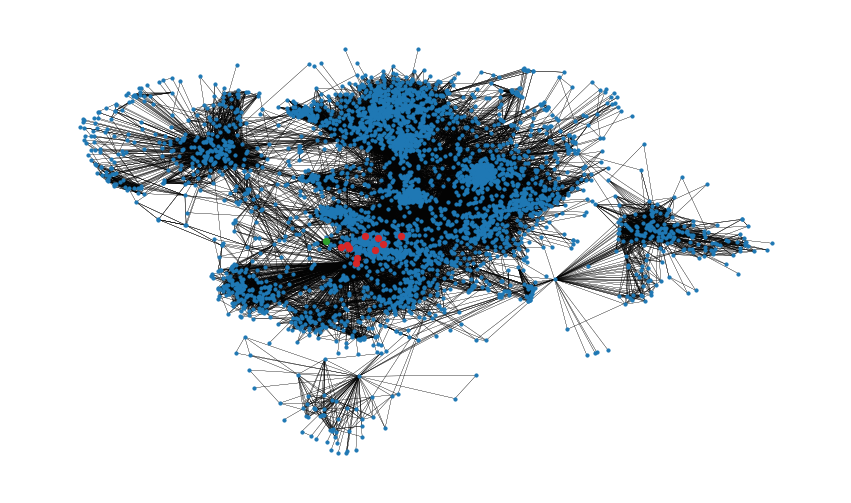

In [18]:
def predict_links(G, df, person_id, N):
    '''
    This function will predict the top N links a node (person_id) should be connected with
    which it is not already connected with in G.
    
    params:
        G (Netowrkx Graph) : The network used to create the embeddings
        df (DataFrame) : The dataframe which has embeddings associated to each node
        person_id (Integer) : The person you're interested 
        N (Integer) : The number of recommended links you want to return
        
    returns:
        This function will return a list of nodes the input node should be connected with.
    '''
    
    # separate target person with all others
    person = df[df.index == person_id]
    
    # potential friends are all the people which the current person doesn't have an edge connecting
    all_nodes = G.nodes()
    other_nodes = [n for n in all_nodes if n not in list(G.adj[person_id]) + [person_id]]
    potential_friends = df[df.index.isin(other_nodes)]
    
    # get similarity of current reader and all other readers
    sim = cosine_similarity(person, potential_friends)[0].tolist()
    idx = potential_friends.index.tolist()
    
    # create a similarity dictionary for this user w.r.t all other users
    idx_sim = dict(zip(idx, sim))
    idx_sim = sorted(idx_sim.items(), key=lambda x: x[1], reverse=True)
    
    recommended_friends = idx_sim[:N]
    people = [rf[0] for rf in recommended_friends]
    return people

person_id = 1000
node_recomm = predict_links(G = G, df = emb_df, person_id = person_id, N = 10)
print(node_recomm)
#TODO: print person_id and recm. friends on network.

pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

options = {"node_size": 40,  "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos, nodelist=[person_id], node_color="tab:green", **options)

options = {"node_size": 40,  "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos, nodelist=node_recomm, node_color="tab:red", **options)

Vizualize Embeddings


[]

<Figure size 432x288 with 0 Axes>

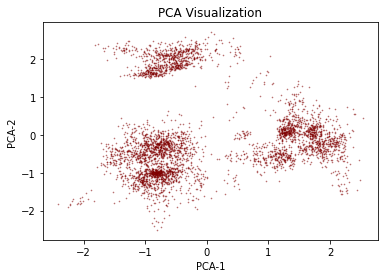

In [19]:
pca = PCA(n_components = 2, random_state = 7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (
    pd.DataFrame(
        pca_mdl,
        columns=['x','y'],
        index = emb_df.index
    )
)
plt.clf()
fig = plt.figure(figsize=(6,4)) 
plt.scatter(
    x = emb_df_PCA['x'],
    y = emb_df_PCA['y'],
    s = 0.4,
    color = 'maroon',
    alpha = 0.5
)
plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.title('PCA Visualization')
plt.plot()